# Haystack agents


In [1]:
from dotenv import load_dotenv
from IPython.display import Markdown, display
import os

           

In [2]:
import os
from haystack import Pipeline, Document
from haystack.utils import Secret
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders.answer_builder import AnswerBuilder
from haystack.components.builders.prompt_builder import PromptBuilder

from haystack.components.converters import MarkdownToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.retrievers.filter_retriever import FilterRetriever

from haystack.components.converters.pypdf import PyPDFToDocument
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack_integrations.components.retrievers.chroma import ChromaQueryTextRetriever
from haystack import component

load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')
model = 'gpt-4o-mini'

def print_results(results, reply_object='llm'):
    return Markdown(result[reply_object]['replies'][0])   

document_store = InMemoryDocumentStore()


/home/roger/anaconda3/envs/haystack2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## In memory vector store : Report results
Retrieving report results from an in memory vector store, using the FilterRetriever on the metadata

### Markdown documents

In [3]:
# from haystack import Pipeline
# from haystack.document_stores.in_memory import InMemoryDocumentStore

model = 'gpt-4o-mini'
report_document_store = InMemoryDocumentStore()

document_pipeline = Pipeline()
document_pipeline.add_component("converter", MarkdownToDocument())
document_pipeline.add_component("cleaner", DocumentCleaner())
document_pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=10))
document_pipeline.add_component("writer", DocumentWriter(document_store=report_document_store))
document_pipeline.connect("converter", "cleaner")
document_pipeline.connect("cleaner", "splitter")
document_pipeline.connect("splitter", "writer")

document_pipeline.run({"converter": {"sources": ["vaud_report_results.md", "report_results.md"], 'meta':[{'doc-id': 'Vaud 2015-11-15 2021-12-31', 'topic':'reports'}, {'doc-id': 'Bern 2015-11-15 2021-12-31', 'topic':'reports'}]}})
prompt_template = """
    Given these documents, answer the question. Please provide the name of the reference(s) where the information came from\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{question}}
    \nAnswer:
    """

report_pipeline = Pipeline()
report_pipeline.add_component(name="retriever", instance=FilterRetriever(document_store=report_document_store))
report_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder")
report_pipeline.add_component(instance=OpenAIGenerator(model=model), name="llm")
report_pipeline.connect("retriever", "prompt_builder.documents")
report_pipeline.connect("prompt_builder", "llm")

Converting markdown files to Documents: 100%|█████| 2/2 [00:00<00:00, 27.58it/s]


🚅 Components
  - retriever: FilterRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

In [4]:
report_document_store

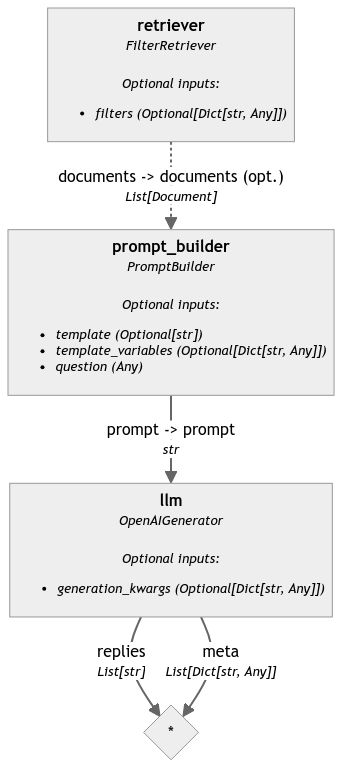

In [5]:
report_pipeline.show()

In [6]:

# some_pdfs = [
    
#     {'topic': 'history of research, methods of research', 'source': 'resources/brief_history_marine_litter.pdf'},
#     {'topic': 'threshold values, methods of calculation', 'source': 'resources/coastline_litter_threshold_value_report_14_9_2020_final.pdf'},
#     {'topic': 'geospatial analysis, land use, feature evaluation', 'source': 'resources/revealing_the_role_of_landuse.pdf'}
# ]

# converter = PyPDFToDocument()

# dox = []
# for element in some_pdfs:
#     results = converter.run(sources=[element['source']], meta={"topic":element['topic']})
#     dox.append(results)

In [7]:
file_names = ['resources/brief_history_marine_litter.pdf', 'resources/coastline_litter_threshold_value_report_14_9_2020_final.pdf', 'resources/revealing_the_role_of_landuse.pdf']
metas = [{'topic': 'history of research, methods of research'},  {'topic': 'threshold values, methods of calculation'}, {'topic': 'geospatial analysis, land use, feature evaluation'}]


context_document_store = ChromaDocumentStore()

pipeline = Pipeline()
pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
pipeline.add_component("splitter", DocumentSplitter(split_by="page", split_length=1))
pipeline.add_component("writer", DocumentWriter(document_store=context_document_store))
pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "writer")

pipeline.run({"converter": {"sources": file_names, "meta": metas}})
# retriever = ChromaQueryTextRetriever(document_store=context_document_store)
# retriever2 = FilterRetriever(document_store)

In [8]:
prompt_template = """
    Given these documents, answer the question. Please provide the name of the reference(s) in your response\nDocuments:
    {% for doc in documents %}
        {{ doc.content }}
    {% endfor %}

    \nQuestion: {{question}}
    \nAnswer:
    """

context_pipeline = Pipeline()
context_pipeline.add_component(name="context_retriever", instance=FilterRetriever(document_store=context_document_store))
context_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder_context")
context_pipeline.add_component(instance=OpenAIGenerator( model=model), name="llm")
context_pipeline.connect("context_retriever", "prompt_builder_context.documents")
context_pipeline.connect("prompt_builder_context", "llm")

🚅 Components
  - context_retriever: FilterRetriever
  - prompt_builder_context: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - context_retriever.documents -> prompt_builder_context.documents (List[Document])
  - prompt_builder_context.prompt -> llm.prompt (str)

In [9]:
def context_pipeline_func(query: str):
    print("context called")
    if 'context_filter' in query:
        result = context_pipeline.run({"retriever": {"filters": context_filters}, "prompt_builder": {"question": query}})

        return {"reply": result["llm"]["replies"][0].content}
    else:
        return "There is no relevant background in my library"

def report_pipeline_func(query: str, filters: dict):
    print("report called")
    if 'report_filters' in query:
        result = context_pipeline.run({"retriever": {"filters": filters}, "prompt_builder": {"question": query}})
        return {"reply": result["llm"]["replies"][0].content}
    else:
        return "There is no survey data for that date range and location, would you like a list of available cantons?"

def call_tools(query, a_report_filter, a_context_filter):

    report = report_pipeline_func(qeury, a_report_filter)
    context = context_pipeline_func(query, a_context_filter)

    return (f'the requested survey results:\n\n {report}\n\nSome relevant background info {context}')


# result[reply_object]['replies'][0]

@component
class AssembleResources:
    def __init__(self, query: str, report_filters: dict, context_filters: dict, context_pipeline: Pipeline, report_pipeline: Pipeline, reply_object: str = 'llm'):
        self.report_filter = report_filters
        self.context_filter = context_filters
        self.query = query
        self.cont_pipeline = context_pipeline
        self.rep_pipeline = report_pipeline
        self.reply_object = reply_object
        

    @component.output_types(report_results=str, context_results=str)
    def run(self):
        r = self.rep_pipeline.run({'retriever': {'filters': self.report_filter}, "prompt_builder":{"question":self.query}})
        c = self.cont_pipeline.run({'context_retriever': {'filters': self.context_filter}, "prompt_builder_context":{"question":self.query}})
        return {'report_results': r[self.reply_object]['replies'][0], 'context_results':c[self.reply_object]['replies'][0]}



In [10]:
context_filters = {
    'topic': {"$in":['threshold values, methods of calculation']},
}

v = ['Vaud 2015-11-15 2021-12-31']
b = ['Bern 2015-11-15 2021-12-31']
combined = [*v,*b]



report_filters = {
    'doc-id': {"$in":combined},
}


In [14]:
f = AssembleResources('What was the average pcs/m in Bern? How is beach litter measured or calculated? What other metrics are used?', report_filters, context_filters, context_pipeline, report_pipeline).run()
Markdown(f['report_results'])

The average pcs/m (pieces per meter) in Bern was approximately 0.71.

Beach litter is typically measured by collecting samples along a defined length of beach, counting the number of litter items found in that length, and then calculating the average number of items per meter. This measurement can provide insights into the density of litter in a given area. 

In addition to average pcs/m, other metrics used in the analysis of beach litter include:
- Total litter count (the overall number of litter items collected).
- Standard deviation (to assess variability in the litter density across samples).
- Percentile distribution (to understand the distribution of litter counts, such as the 5th, 25th, 50th, 75th, and 95th percentiles).
- Material composition (the breakdown of litter items by material type, such as plastic, metal, paper, etc.).
- Specific counts of different types of litter (e.g., cigarette filters, food wrappers).
- Sampling stratification (assessments of the land-use features surrounding the survey locations, which could impact litter presence).
- Regression analysis results (to evaluate the relationship between land use and litter density).

In [15]:
# f = AssembleResources('Which had the highest average pieces per meter Vaud or Bern?', report_filters, context_filters, context_pipeline, report_pipeline).run()
Markdown(f['context_results'])

The documents provided do not specifically mention the average number of litter pieces per meter (pcs/m) in Bern. They present information regarding a European threshold value for macro litter on coastlines but do not provide city-specific data.

Beach litter is typically measured or calculated using the following methodologies:

1. **Survey Length**: Litter is surveyed along a set length of beach, commonly 100 meters. This standardization helps in achieving comparability across different monitoring sites.

2. **Data Collection**: Surveys are conducted multiple times a year, ideally in each season, to account for seasonal variations in litter accumulation.

3. **Data Clean-Up**: The collected data undergo cleaning to exclude fragments of litter that are not comparable (like smaller pieces) and to focus on macro-sized materials typically larger than 2.5 cm.

4. **Abundance Calculation**: The total abundance of litter per survey is calculated by summing up the remaining litter types and normalizing to 100 m of beach.

5. **Statistical Methods**: Various statistical methods are employed to calculate threshold values based on percentiles (e.g., the 10th percentile, 15th percentile), which allows for robust assessment values while accounting for uncertainties.

Other metrics that are commonly used in beach litter assessments include:

- **Median Values**: The median number of litter pieces is considered a robust indicator to assess beach litter levels as it is less influenced by extreme values compared to mean values.

- **Mean Values**: While mean values can provide an overview, they are more susceptible to distortion from outliers.

- **Confidence Intervals**: Calculated to assess the uncertainty around the median assessment values, ensuring statistical reliability.

In summary, beach litter assessments utilize a combination of systematic survey methodologies, statistical calculations for threshold values, and the use of metrics like mean and median to evaluate the litter's impact on coastal environments.

In [ ]:
from haystack import component

@component
class CombinedAnswer:
  """
  A component generating personal welcome message and making it upper case
  """
  @component.output_types(welcome_text=str, note=str)
  def run(self, name:str):
    return {"welcome_text": ('Hello {name}, welcome to Haystack!'.format(name=name)).upper(), "note": "welcome message is ready"}


In [ ]:
prompt_template = """
    Given the results from the report and the results of the litterature review  documents, answer the question. Please provide the name of the reference(s) in your response\nDocuments:
    \nReport results: {{report_results}}
    \n
    \nLitterature review: {{context_results}}
    {% endfor %}

    \nQuestion: {{question}}
    \nAnswer:
    """

context_pipeline = Pipeline()
# context_pipeline.add_component(name="context_retriever", instance=FilterRetriever(document_store=context_document_store))
# context_pipeline.add_component(instance=PromptBuilder(template=prompt_template), name="prompt_builder_context")
# context_pipeline.add_component(instance=OpenAIGenerator( model=model), name="llm")
# context_pipeline.connect("context_retriever", "prompt_builder_context.documents")
# context_pipeline.connect("prompt_builder_context", "llm")

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Chroma vector store



In [ ]:
break

In [ ]:
# tools = [
#     {
#         "type": "function",
#         "function": {
#             "name": "context_pipeline_func",
#             "description": "Retrieves background information about the query from matching meta-data",
#             "parameters": {
#                 "type": "object",
#                 "properties": {
#                     "query": {
#                         "type": "string",
#                         "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
#                     },
#                 },
#                 "required": ["query"],
#             },
#         },
#     },
#     {
#         "type": "function",
#         "function": {
#             "name": "report_pipeline_func",
#             "description": "Retrieves the results from survey report documents based on the matching meta-data",
#             "parameters": {
#                 "type": "object",
#                 "properties": {
#                     "query": {
#                         "type": "string",
#                         "description": "The query to use in the search. Infer this from the user's message. It should be a question or a statement",
#                     },
#                 },
#                 "required": ["query"],
#             },
#         },
#     },
# ]





In [ ]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.readers import ExtractiveReader
from haystack.components.embedders import SentenceTransformersTextEmbedder


retriever = InMemoryEmbeddingRetriever(document_store=document_store)
reader = ExtractiveReader()
reader.warm_up()

extractive_qa_pipeline = Pipeline()

extractive_qa_pipeline.add_component(instance=SentenceTransformersTextEmbedder(model=model), name="embedder")
extractive_qa_pipeline.add_component(instance=retriever, name="retriever")
extractive_qa_pipeline.add_component(instance=reader, name="reader")

extractive_qa_pipeline.connect("embedder.embedding", "retriever.query_embedding")
extractive_qa_pipeline.connect("retriever.documents", "reader.documents")


In [ ]:
Markdown(f['context_results'])

In [ ]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk
import gradio as gr
import json
messages = [
    ChatMessage.from_system(
        "reply with at least a helpfull message"
    ),
    ChatMessage.from_user("What were the regression results for Vaud ? What were the regression results for Bern ? Whats the difference?.? context_filter, report_filters")
]

chat_generator = OpenAIChatGenerator(model=model, streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages generation_kwargs={"tools": tools})

In [ ]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.components.generators.utils import print_streaming_chunk

chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo", streaming_callback=print_streaming_chunk)
response = chat_generator.run(messages=messages)


In [ ]:
response["replies"][0].meta["finish_reason"] == "tool_calls"

In [ ]:
response["replies"]

In [ ]:
from haystack.dataclasses import ChatMessage
from haystack.components.generators.chat import OpenAIChatGenerator

chat_generator = OpenAIChatGenerator(model="gpt-3.5-turbo")
response = None
messages = [
    ChatMessage.from_system(
        "Don't make assumptions about what values to plug into functions. Ask for clarification if a user request is ambiguous."
    )
]

In [ ]:
response["replies"][0].content

In [ ]:
import json

## Parse function calling information
function_call = json.loads(response["replies"][0].content)[0]
function_name = function_call["function"]["name"]
function_args = json.loads(function_call["function"]["arguments"])
print("Function Name:", function_name)
print("Function Arguments:", function_args)

## Find the correspoding function and call it with the given arguments
available_functions = {"rag_pipeline_func": rag_pipeline_func, "get_current_weather": get_current_weather}
function_to_call = available_functions[function_name]
function_response = function_to_call(**function_args)
print("Function Response:", function_response)


In [ ]:
response

In [ ]:
report_filters